**REQUIRED PACKAGES**

In order to access the data, we need to make sure that all the required packages
are installed.

In [1]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog, teamgamelog, playercareerstats
import matplotlib.pyplot as plt
import numpy as np
import time

First, determine the player who's stats we want to look at.

In [2]:
myPlayer = "LeBron James"

Then, use the NBA API to determine that player's ID number.

In [3]:
playerInfo = players.find_players_by_full_name(myPlayer)[0]
print(playerInfo['id'])

2544


Let's look at all of the seasons that this player has played, and get their stats.

In [4]:
playerGames = {}
for year in range(3, 25):
	time.sleep(3.5)
	seasonString = '20'
	startYear = str(0) + str(year)
	if len(startYear) != 2:
		startYear = startYear[1:]
	endYear = str(0) + str(year + 1)
	if len(endYear) != 2:
		endYear = endYear[1:]
	seasonString = seasonString + startYear + '-' + endYear
	gameLog = playergamelog.PlayerGameLog(player_id=playerInfo['id'], season=seasonString).get_dict()
	playerGames[seasonString] = []
	for game in reversed(gameLog['resultSets'][0]['rowSet']):
		playerGames[seasonString].append(game)

In [5]:
allGames = {}
playerCareer = playercareerstats.PlayerCareerStats(player_id=playerInfo['id']).get_dict()
for season in playerCareer['resultSets'][0]['rowSet']:
	time.sleep(3.5)
	teamSeason = teamgamelog.TeamGameLog(team_id=season[3], season=season[1]).get_dict()
	allGames[season[1]] = []
	for game in reversed(teamSeason['resultSets'][0]['rowSet']):
		allGames[season[1]].append(game)

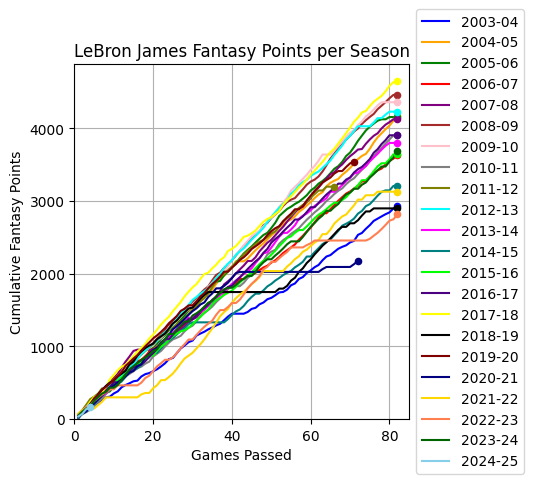

In [6]:
colors = [
    'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
    'magenta', 'teal', 'lime', 'indigo', 'yellow', 'black', 'maroon', 'navy', 'gold', 'coral',
    'darkgreen', 'skyblue'
]

ppg = []

for x, season in enumerate(playerGames.keys()):
	fantasyPoints = []
	offset = 0
	
	for i, game in enumerate(allGames[season]):
		if (len(playerGames[season]) == i - offset):
			fantasyPoints.append(0)
			offset += 1
			continue
		elif game[2] != playerGames[season][i - offset][3]:
			fantasyPoints.append(0)
			offset += 1
			continue
		
		myGame = playerGames[season][i - offset]

		fieldGoalsMade = 2 * myGame[7]
		fieldGoalsAttempted = -1 * myGame[8]
		freeThrowsMade = 1 * myGame[13]
		freeThrowsAttempted = -1 * myGame[14]
		threePointersMade = 1 * myGame[10]
		rebounds = 1 * myGame[18]
		assists = 2 * myGame[19]
		steals = 4 * myGame[20]
		blocks = 4 * myGame[21]
		turnovers = -2 * myGame[22]
		points = 1 * myGame[24]

		fantasyPoints.append(
			fieldGoalsMade +
			fieldGoalsAttempted +
			freeThrowsMade +
			freeThrowsAttempted +
			threePointersMade +
			rebounds +
			assists +
			steals +
			blocks +
			turnovers +
			points
		)
	
	ppg.append(fantasyPoints)

	plt.plot(range(1, len(fantasyPoints) + 1), np.cumsum(fantasyPoints), linestyle='-', label=season, color=colors[x])
	plt.scatter(len(fantasyPoints), np.cumsum(fantasyPoints)[-1], s=20, zorder=100, color=colors[x])

plt.grid(True)
plt.title("LeBron James Fantasy Points per Season")
plt.xlabel("Games Passed")
plt.ylabel("Cumulative Fantasy Points")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.xlim(left=0, right=85)
plt.ylim(bottom=0)
plt.show()